In [2]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [3]:
env = BlackjackEnv()

In [4]:
def create_random_policy(nA):
    """
    Creates a random policy function.
    
    Args:
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities
    """
    A = np.ones(nA, dtype=float) / nA
    def policy_fn(observation):
        return A
    return policy_fn

In [25]:
def create_greedy_policy(Q):
    """
    Creates a greedy policy based on Q values.
    
    Args:
        Q: A dictionary that maps from state -> action values
        
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities.
    """
    
    def policy_fn(observation):
        A = np.zeros_like(Q[state], dtype=float)
        A[np.argmax(Q[observation])] = 1.0
        return A
    return policy_fn

In [26]:
def generate_episode(env, policy):
    # generate an episode
    old_observation = env.reset()
    G = 0
    episode_recap = {}
    # take large number of steps just in case
    for t in range(10000):
        probs = policy(old_observation)
        action = np.random.choice(np.arange(len(probs)), p=probs)
        new_observation, reward, done, _ = env.step(action)
        episode_recap[t] = (old_observation, action, reward)
        old_observation = new_observation
        if done:
            break
    return episode_recap

In [27]:
def mc_control_importance_sampling(env, num_episodes, behavior_policy, discount_factor=1.0):
    """
    Monte Carlo Control Off-Policy Control using Weighted Importance Sampling.
    Finds an optimal greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        behavior_policy: The behavior to follow while generating episodes.
            A function that given an observation returns a vector of probabilities for each action.
        discount_factor: Gamma discount factor.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities. This is the optimal greedy policy.
    """
    
    # The final action-value function.
    # A dictionary that maps state -> action values
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    C = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Our greedily policy we want to learn
    target_policy = create_greedy_policy(Q)
    behavior_policy = create_random_policy(env.action_space.n)
    
    for i in range(num_episodes):
        G = 0
        W = 1
        episode_recap = generate_episode(env, behavior_policy)
        state_action_pairs = [(value[0], value[1]) for value in episode_recap.values()]

        for t in list(episode_recap.keys())[::-1]:
            G = discount_factor*G + episode_recap[t][2]         
            state = episode_recap[t][0]
            action = episode_recap[t][1]
            C[state][action] += W
            Q[state][action] += (W / C[state][action]) * (G - Q[state][action])
            if action !=  np.argmax(target_policy(state)):
                break
            W *= behavior_policy(state)[action]
        
    return Q, target_policy

In [28]:
random_policy = create_random_policy(env.action_space.n)
Q, policy = mc_control_importance_sampling(env, num_episodes=500000, behavior_policy=random_policy)

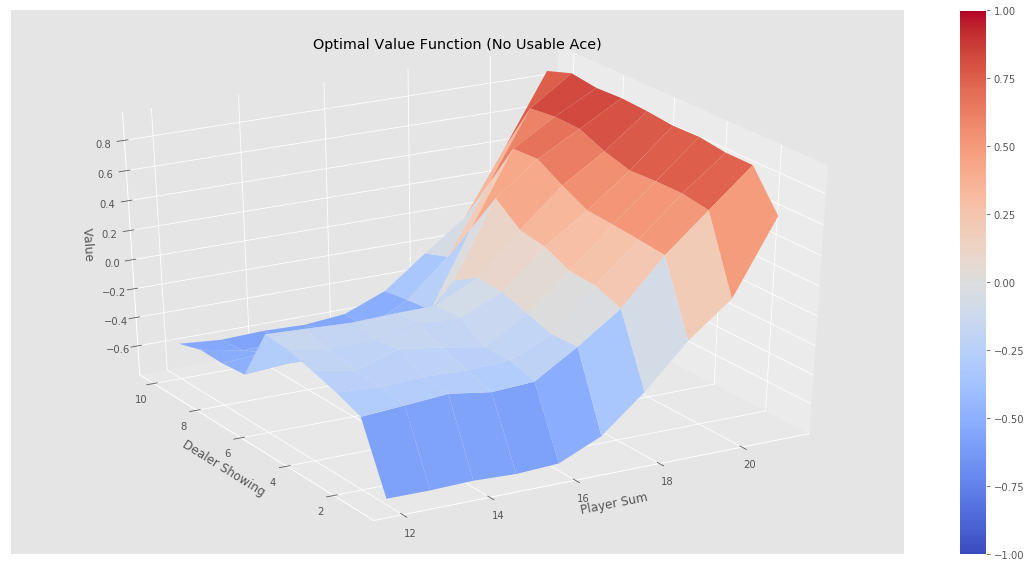

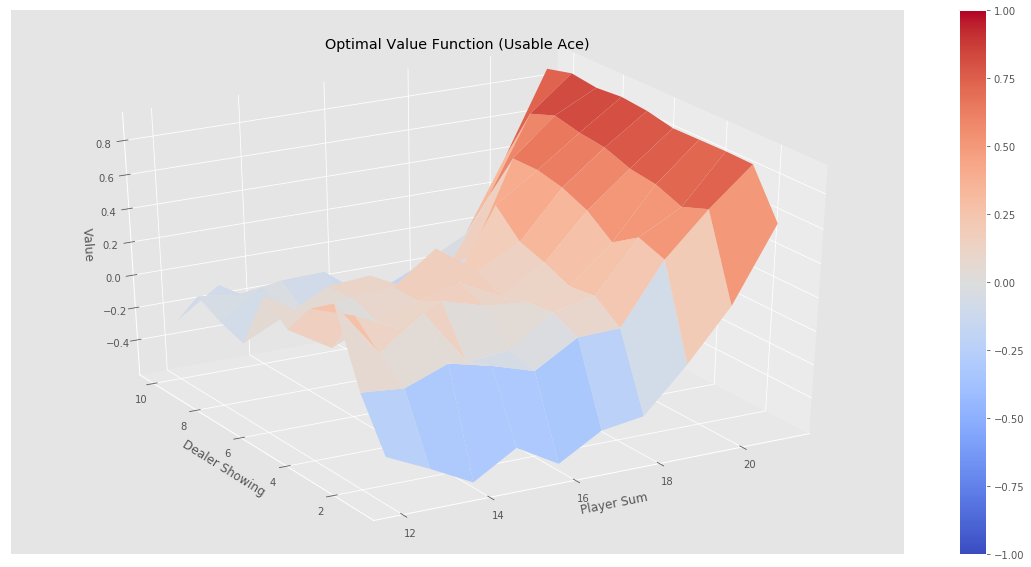

In [29]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, action_values in Q.items():
    action_value = np.max(action_values)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")